#A Look at Question Answering Problem - as an Embedding based Retrieval

#### *Abstract:* Here we attempt to solve a Question Answering (QA) system problem as a information retrieval problem. We derived inspiration from Overveiw QA pipeline described in Bithiah Yuan [4] thesis work. Though this approach is impressive and produced some interesting results, the non-factoid based selection require word matches for a answer to be in the potential answer list. As a result we will fail to pick answers that have semantic relevance but have no words in common. In this paper we would like to employ 3 following approaches: (1) a pure informational retrieval (IR) based approach that uses TF-IDF (our baseline model) [6], (2) Yuan's Overview QA pipeline using BERT transformer [4], and (3) A Two-tower model that uses the question and answer towers. Finally we have analyzed our results with rank aware metrics[8].

## Following are some necessary installs and imports

In [1]:
!pip install pyserini
!pip install faiss

!apt install libomp-dev
!python -m pip install --upgrade faiss faiss-gpu
import faiss

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 109.5 MB 26 kB/s 
     |████████████████████████████████| 4.4 MB 20.9 MB/s 
     |████████████████████████████████| 1.2 MB 47.0 MB/s 
     |████████████████████████████████| 13.5 MB 28.7 MB/s 
     |████████████████████████████████| 2.0 MB 35.8 MB/s 
     |████████████████████████████████| 1.3 MB 47.6 MB/s 
     |████████████████████████████████| 4.9 MB 45.3 MB/s 
     |████████████████████████████████| 188 kB 54.0 MB/s 
     |████████████████████████████████| 46 kB 4.5 MB/s 
     |████████████████████████████████| 6.6 MB 43.1 MB/s 
     |████████████████████████████████| 596 kB 47.9 MB/s 
     |████████████████████████████████| 101 kB 11.9 MB/s 
     |████████████████████████████████| 86 kB 6.5 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
 

In [2]:
!pip install pydot --quiet
!pip install gensim==3.8.3 --quiet
!pip install tensorflow-datasets --quiet
!pip install -U tensorflow-text --quiet
!pip install transformers --quiet
!pip install pydot --quiet

     |████████████████████████████████| 24.2 MB 1.5 MB/s 
     |████████████████████████████████| 4.6 MB 6.8 MB/s 
     |████████████████████████████████| 511.7 MB 6.5 kB/s 
     |████████████████████████████████| 438 kB 55.8 MB/s 
     |████████████████████████████████| 5.8 MB 34.3 MB/s 
     |████████████████████████████████| 1.6 MB 46.5 MB/s 


In [5]:
!pip install -q tensorflow-recommenders
!pip install -q scann

     |████████████████████████████████| 88 kB 4.5 MB/s 
     |████████████████████████████████| 11.2 MB 7.0 MB/s 


In [3]:
import pandas as pd
import regex as re
import csv
from itertools import islice
import pickle
import numpy as np
import json
import os
import sys
import argparse
from pathlib import Path
import pprint
import tempfile
import re
from typing import Dict, Text

import sklearn as sk
from sklearn.model_selection import train_test_split
import nltk
from nltk.corpus import reuters
from nltk.data import find

import matplotlib.pyplot as plt
import numpy as np
# os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
#from pyserini.search as pysearch

from pyserini.search import SimpleSearcher

In [17]:
import numpy as np
from sklearn.metrics import ndcg_score
from sklearn.metrics import average_precision_score

In [6]:
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.layers import Embedding, Input, Dense, Lambda
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K
import tensorflow_datasets as tfds
import tensorflow_text as tf_text
import tensorflow_recommenders as tfrs

from transformers import BertTokenizer, TFBertModel

## FiQA dataset

Here we load the FiQA dataset. The FiQA 2018 open challenge test collection is based on the use of unstructured text documents from different financial open data sources in English. This data comes in two flavors (a) Task 1: sentiment analysis train, and (b) Task 2:  Opinion-based QA. We are interested only in the QA dataset in task 2 collection.  The task 2 collection consists of three files:

- FiQA question.tsv
- FiQA question-doc.tsv
- FiQA doc.tsv. 

1. FiQA_train_question_final.tsv: This file contains a set of natural language questions on topics related to finance and investment. It consists ofl a .tsv file with tab-seaprated columns:
  - qid: question id number;
  - question: question text;
  - timestamp: the date and time value that represents when the question was posted.

2. FiQA_train_question_doc_final.tsv: This file contains information about the corresponding question-answer matchings. It also columns:
  - qid: question id number;
  - docid: document id number.

3. FiQA_train_doc_final.tsv: This file contains a set of answers and comments that the systems need to find the matching one.

In the dataset, for each question we have one or many relevant answers with no scores of relevance. So, we will have to assume all answers as equally relevant.

In the following cell we change directory to FinBERT-QA and import all the code relevant to processing the data

### Here we mount my google drive to this notebook.

In [8]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Mounted at /gdrive
/gdrive


In the following cell we change directory to FinBERT-QA and import all the code relevant to processing the data

In [9]:
%cd /gdrive/MyDrive/nlp-yuan_code/FinBERT-QA
from src.process_data import *

/gdrive/MyDrive/nlp-yuan_code/FinBERT-QA


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Now we read the data in to memory. Here we will read the provided three files into three pandas dataframe collection, queries, and qid_docid. 'collection' is a pair of (docid (int), and doc (str)). 'queries' is a pair of qid (int), and question (str). Similarly, 'qid_docid is a pair of qid(int) and docid(int).

In [10]:
data_path = '/gdrive/MyDrive/nlp-data/nlp-qa-datasets/FiQA/FiQA_train_task2/'
# Document id and Answer text
collection = load_answers_to_df(data_path+"FiQA_train_doc_final.tsv")
# Question id and Question text
queries = load_questions_to_df(data_path+"FiQA_train_question_final.tsv")
# Question id and Answer id pair
qid_docid = load_qid_docid_to_df(data_path+"FiQA_train_question_doc_final.tsv")

## Baseline Approach:

The following code reads the data and splits it into train and test datasets.  Each entry in the data set includes the question followed by answer labels as provided in the dataset and finally the list of candidate answers (50 candidates) as selected by the inverted index. 

In [13]:
fiqa_index = "/gdrive/MyDrive/nlp-yuan_code/FinBERT-QA/retriever/lucene-index-fiqa/"


def split_label(qid_docid):
    """
    Split question answer pairs into train, test, validation sets.

    Returns:
        train_label: Dictonary
            key - question id
            value - list of relevant docids
        test_label: Dictonary
            key - question id
            value - list of relevant docids
        valid_label: Dictonary
            key - question id
            value - list of relevant docids
    ----------
    Arguments:
        qid_docid: Dataframe containing the question id and relevant docids
    """
    # Group the answers for each question into a list
    qid_docid = qid_docid.groupby(['qid']).agg(lambda x: tuple(x)).applymap(list).reset_index()
    # Split data
    train_set, test_set = train_test_split(qid_docid, test_size=0.05)
    #train_set, valid_set = train_test_split(train, test_size=0.1)
    # Expand the list of docids into individual rows to represent a single sample
    train_data = train_set.explode('docid')
    test_data = test_set.explode('docid')
    #valid_data = valid_set.explode('docid')

    # Convert data into dictionary - key: qid, value: list of relevant docid
    train_label = label_to_dict(train_data)
    test_label = label_to_dict(test_data)
    #valid_label = label_to_dict(valid_data)

    return train_label, test_label

def split_question(train_label, test_label, queries):
    """
    Split questions into train, test, validation sets.

    Returns:
        train_questions: Dataframe with qids
        test_questions: Dataframe with qids
        valid_questions: Dataframe with qids
    ----------
    Arguments:
        train_label: Dictionary contraining qid and list of relevant docid
        test_label: Dictionary contraining qid and list of relevant docid
        valid_label: Dictionary contraining qid and list of relevant docid
        queries: Dataframe containing the question id and question text
    """
    # Get a list of question ids
    train_q = list(train_label.keys())
    test_q = list(test_label.keys())

    # Split question dataframe into train, test, valid set
    train_questions = queries[queries['qid'].isin(train_q)]
    test_questions = queries[queries['qid'].isin(test_q)]

    return train_questions, test_questions

def create_dataset(question_df, labels, cands_size):
    """Retrieves the top-k candidate answers for a question and
    creates a list of lists of the dataset containing the question id,
    list of relevant answer ids, and the list of answer candidates

    Returns:
        dataset: list of list in the form [qid, [pos ans], [ans candidates]]
    ----------
    Arguments:
        question_df: Dataframe containing the qid and question text
        labels: Dictonary containing the qid to text map
        cands_size: int - number of candidates to retrieve
    """
    dataset = []
    # Calls retriever
    searcher = SimpleSearcher(fiqa_index)
    # For each question
    for i, row in question_df.iterrows():
        qid = row['qid']
        tmp = []
        # Append qid
        tmp.append(qid)
        # Append list of relevant docs
        tmp.append(labels[qid])
        # Retrieves answer candidates
        cands = []
        cands_score = []
        query = row['question']
        query = re.sub('[£€§]', '', query)
        hits = searcher.search(query, k=cands_size)

        for docid in range(0, len(hits)):
            cands.append(int(hits[docid].docid))
            cands_score.append(hits[docid].score)
        # Append candidate answers
        tmp.append(cands)
        tmp.append(cands_score)
        dataset.append(tmp)

    return dataset

def get_dataset(query_path, labels_path, cands_size):
    """Splits the dataset into train, validation, and test set and creates
    the dataset form for training, validation, and testing.

    Returns:
        train_set: list of list in the form [qid, [pos ans], [ans candidates]]
        valid_set: list of list in the form [qid, [pos ans], [ans candidates]]
        test_set: list of list in the form [qid, [pos ans], [ans candidates]]
    ----------
    Arguments:
        query_path: str - path containing a list of qid and questions
        labels_path: str - path containing a list of qid and relevant docid
        cands_size: int - number of candidates to retrieve
    """
    # Question id and Question text
    queries = load_questions_to_df(query_path)
    # Question id and Answer id pair
    qid_docid = load_qid_docid_to_df(labels_path)
    # qid to docid label map
    labels = label_to_dict(qid_docid)
    train_label, test_label = split_label(qid_docid)
    # Split Questions
    train_questions, test_questions = split_question(train_label, test_label, queries)

    print("\nGenerating training set...\n")
    train_set = create_dataset(train_questions, labels, cands_size)
    print("Generating test set...\n")
    test_set = create_dataset(test_questions, labels, cands_size)

    return train_set, test_set

In the following cell, we are generating the train and test dataset. Each entry in the data set includes the question followed by answer labels as provided in the dataset and finally the list of candidate answers.

In [14]:
query_path = "/gdrive/MyDrive/nlp-data/nlp-qa-datasets/FiQA/FiQA_train_task2/FiQA_train_question_final.tsv"
labels_path = "/gdrive/MyDrive/nlp-data/nlp-qa-datasets/FiQA/FiQA_train_task2/FiQA_train_question_doc_final.tsv"
train_set, test_set = get_dataset(query_path, labels_path, 50)


Generating training set...

SimpleSearcher class has been deprecated, please use LuceneSearcher from pyserini.search.lucene instead
Generating test set...

SimpleSearcher class has been deprecated, please use LuceneSearcher from pyserini.search.lucene instead


In [15]:
print(len(train_set), len(test_set))

6315 333


In [16]:
# Cleaning data
empty_docs, empty_id = get_empty_docs(collection)
# Remove empty answers from collection of answers
collection_cleaned = collection.drop(empty_id)
# Remove empty answers from qa pairs
qid_docid = qid_docid[~qid_docid['docid'].isin(empty_docs)]

print("Number of answers after cleaning: {}".format(len(collection_cleaned)))
print("Number of QA pairs after cleaning: {}".format(len(qid_docid)))

Number of answers after cleaning: 57600
Number of QA pairs after cleaning: 17072


Here we have listed the util functions to generate metrics for respective approaches.

In [24]:
def run_baseline(data):
  ap = []
  rr = []
  cg = []


  #for i, seq in enumerate(tqdm(train_set)):
  for k, seq in enumerate(data):
    qid, ans_labels, cands, cands_score = seq[0], seq[1], seq[2], seq[3]
    
    # Map question id to text
    #q_text = qid_to_text[qid]

    max_width = -1
    rr_ = 0
    ap_ = 0.0
    precision_ = 0.0
    relcnt_ = 0

    top_k = 10

    # For each answer in the candidates
    for i in range(top_k):
      docid = cands[i]
      if docid in ans_labels and rr_ == 0:
        rr_ = 1/(i+1)
    
    relscores = [1 if docid in ans_labels else 0 for docid in cands[:top_k]]
    pos = [1.0/(i+1) for i in range(top_k)]
    ap_ = average_precision_score(relscores,pos) if sum(relscores) != 0 else 0 

    #print(ap_, [1 if docid in ans_labels else 0 for docid in cands[:top_k]], [1.0/(i+1) for i in range(top_k)])
    relscores = np.asarray([[np.log2(cands_score[i]) if (cands[i] in ans_labels) else 0.001 for i in range(top_k)]])
    pos = np.asarray([[np.log2(i+2) for i in range(top_k)]])

    cg_ = ndcg_score(relscores, pos)

    ap.append(ap_)
    rr.append(rr_)
    cg.append(cg_)
  return rr, ap, cg

In the following cell we are generating the metrics for our baseline approach.

In [116]:
rr, ap, cg = run_baseline(test_set)

print('Mean Reciprocal Rank (MRR):', np.mean(rr))
print('Mean average Precision (MAP)', np.mean(ap))
print('Normalized Discounted Cumulative Gain (NDCG)', np.mean(cg))

Mean Reciprocal Rank (MRR): 0.294325277658611
Mean average Precision (MAP) 0.28100481433814767
Normalized Discounted Cumulative Gain (NDCG) 0.7067188071447419


## Two Tower Approach:

The Two Tower has a separate question tower and an answer tower with a final dot product that computes the relavance between a given question and an answer. The answer tower takes the features from the given answer and generates an answer embedding for it. The features here are the encodings for the words found in the answer. Similarly, the question tower takes the encodings for the words in the question.  Finally, we do a simple dot product based on the two embeddings as a measure of how likely the pairs are relevant. So, basically we train the network for each positive question and answer combination such that we maximize the dot product measure.

In [117]:
embedding_dimension = 64

### Data processing

Cleanup answers and questions and build Maps such qid_to_text, docid_id_t_text, docid_to_tokenized_text

In [118]:
processed_answers = process_answers(collection_cleaned)
processed_questions = process_questions(queries)

In [119]:
word2index, word2count = create_vocab(processed_answers, processed_questions)

print("Vocab size: {}".format(len(word2index)))
print("Top {} common words: {}".format(35, Counter(word2count).most_common(35)))

Vocab size: 85034
Top 35 common words: [('the', 371203), ('to', 233559), ('a', 201620), ('you', 166702), ('and', 163066), ('of', 157574), ('is', 129894), ('in', 120019), ('that', 111416), ('for', 89366), ('it', 83822), ('i', 74100), ('your', 68153), ('are', 67255), ('if', 60689), ('be', 59266), ('on', 58382), ('have', 55754), ('as', 50088), ('this', 49868), ('not', 49227), ('or', 46080), ('with', 45894), ('they', 44485), ('but', 41690), ('can', 38863), ('will', 36865), ('at', 35548), ('an', 31392), ('money', 31003), ('so', 29980), ('$', 29096), ('would', 28750), ('from', 28582), ('more', 27378)]


In [120]:
qid_to_text, docid_to_text = id_to_text(collection, queries)
qid_to_tokenized_text, docid_to_tokenized_text = id_to_tokenized_text(processed_answers, processed_questions)

Generate unique qids, aids, and (qid, aid) pairs.

In [121]:
def generate_ids(data):
  qids = []
  aids = []
  qa_pairs = []


  #for i, seq in enumerate(tqdm(train_set)):
  for i, seq in enumerate(data):
    qid, ans_labels, cands = seq[0], seq[1], seq[2]
    #print (qid, ans_labels, cands)
    

    # For each answer in the candidates
    for docid in ans_labels:
      qids.append(qid)
      aids.append(docid)
      qa_pairs.append((qid, docid))

  unique_qids = np.unique(qids)
  unique_aids = np.unique(aids)
  return unique_qids, unique_aids, qa_pairs

data = []
data.extend(train_set)
data.extend(test_set)
      
qids, aids, qa_pairs = generate_ids(data)

In [122]:
unique_questions = np.unique([qid_to_text[qid] for qid in qids])

question_model = tf.keras.Sequential([
  tf.keras.layers.StringLookup(
      vocabulary=unique_questions, mask_token=None),
  # We add an additional embedding to account for unknown tokens.
  tf.keras.layers.Embedding(len(qids) + 1, embedding_dimension)
])

unique_answers = np.unique([docid_to_text[aid] for aid in aids])

answer_model = tf.keras.Sequential([
  tf.keras.layers.StringLookup(
      vocabulary=unique_answers, mask_token=None),
  # We add an additional embedding to account for unknown tokens.
  tf.keras.layers.Embedding(len(aids) + 1, embedding_dimension)
])

Careate the plumbing for the two-tower model.

In [123]:
questions = tf.data.Dataset.from_tensor_slices([qid_to_text[qid] if isinstance(qid_to_text.get(qid),str) else '' for qid, aid in qa_pairs])
answers = tf.data.Dataset.from_tensor_slices([docid_to_text[aid] if isinstance(docid_to_text.get(aid),str) else '' for qid, aid in qa_pairs])

metrics = tfrs.metrics.FactorizedTopK(
  candidates=answers.batch(128).map(answer_model)
)
task = tfrs.tasks.Retrieval(
  metrics=metrics
)

In [124]:
class QAModel(tfrs.Model):

  def __init__(self, question_model, answer_model):
    super().__init__()
    self.question_model: tf.keras.Model = question_model
    self.answer_model: tf.keras.Model = answer_model
    self.task: tf.keras.layers.Layer = task

  def compute_loss(self, features: Dict[Text, tf.Tensor], training=False) -> tf.Tensor:
    # We pick out the user features and pass them into the user model.
    q_embeddings = self.question_model(features["question"])
    # And pick out the movie features and pass them into the movie model,
    # getting embeddings back.
    a_embeddings = self.answer_model(features["answer"])

    # The task computes the loss and the metrics.
    return self.task(q_embeddings, a_embeddings)

In [125]:
print(len(qids), len(aids), len(qa_pairs))

6648 17110 17110


In [126]:
ds = tf.data.Dataset.zip((questions, answers))
ds = ds.map(lambda x, y : {"question": x, "answer": y})

tf.random.set_seed(42)
shuffled = ds.shuffle(17_110, seed=42, reshuffle_each_iteration=False)

Shuffle the dataset and create cached and train and test datasets.

In [127]:
cached_train = shuffled.shuffle(17_110).batch(1300)
cached_test =  shuffled.take(856).batch(150)

Run the two-tower model for 5 epochs

In [128]:
model = QAModel(question_model, answer_model)
model.compile(optimizer=tf.keras.optimizers.Adagrad(learning_rate=0.1))

model.fit(cached_train, epochs=5)

Epoch 1/5
14/14 [==============================] - 34s 2s/step - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 1.7534e-04 - factorized_top_k/top_10_categorical_accuracy: 4.0912e-04 - factorized_top_k/top_50_categorical_accuracy: 0.0030 - factorized_top_k/top_100_categorical_accuracy: 0.0058 - loss: 8228.0209 - regularization_loss: 0.0000e+00 - total_loss: 8228.0209
Epoch 2/5
14/14 [==============================] - 34s 2s/step - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.3025 - factorized_top_k/top_10_categorical_accuracy: 0.4309 - factorized_top_k/top_50_categorical_accuracy: 0.7208 - factorized_top_k/top_100_categorical_accuracy: 0.8444 - loss: 8180.6493 - regularization_loss: 0.0000e+00 - total_loss: 8180.6493
Epoch 3/5
14/14 [==============================] - 33s 2s/step - factorized_top_k/top_1_categorical_accuracy: 3.5067e-04 - factorized_top_k/top_5_categorical_

In [129]:
model.evaluate(cached_test, return_dict=True)

6/6 [==============================] - 3s 375ms/step - factorized_top_k/top_1_categorical_accuracy: 0.2150 - factorized_top_k/top_5_categorical_accuracy: 0.8271 - factorized_top_k/top_10_categorical_accuracy: 0.9486 - factorized_top_k/top_50_categorical_accuracy: 0.9988 - factorized_top_k/top_100_categorical_accuracy: 1.0000 - loss: 443.6464 - regularization_loss: 0.0000e+00 - total_loss: 443.6464


{'factorized_top_k/top_100_categorical_accuracy': 1.0,
 'factorized_top_k/top_10_categorical_accuracy': 0.9485981464385986,
 'factorized_top_k/top_1_categorical_accuracy': 0.21495327353477478,
 'factorized_top_k/top_50_categorical_accuracy': 0.9988317489624023,
 'factorized_top_k/top_5_categorical_accuracy': 0.827102780342102,
 'loss': 308.23516845703125,
 'regularization_loss': 0,
 'total_loss': 308.23516845703125}

In [130]:
scann_index = tfrs.layers.factorized_top_k.ScaNN(model.question_model)
scann_index.index_from_dataset(
  tf.data.Dataset.zip((answers.batch(100), answers.batch(100).map(model.answer_model)))
)

In [131]:
# Get recommendations.
_, cands = scann_index(tf.constant([qid_to_text[5]]))

print(f'QUESTION: ', qid_to_text[5])
print(f"Recommendations for user 42: {cands[0, :10]}")

QUESTION:  Starting a new online business
Recommendations for user 42: [b"Most US states have rules that go something like this: You will almost certainly have to pay some registration fees, as noted above.  Depending on how you organize, you may or may not need to file a separate tax return for the business. (If you're sole proprietor for tax purposes, then you file on Schedule C on your personal Form 1040.)  Whether or not you pay taxes depends on whether you have net income.  It's possible that some losses might also be deductible. (Note that you may have to file a return even if you don't have net income - Filing and needing to pay are not the same since your return may indicate no tax due.)  In addition, at the state level, you may have to pay additional fees or taxes beyond income tax depending on what you sell and how you sell it. (Sales tax, for example, might come into play as might franchise taxes.)  You'll need to check your own state law for that. As always, it could be wis

In [132]:
text_to_docid = dict([ (docid_to_text[k], k) for k in docid_to_text])

def run_twotower_scores(data):
  ap = []
  rr = []
  cg = []
  skipcnt = 0

  #for i, seq in enumerate(tqdm(train_set)):
  for j, seq in enumerate(data):
    qid, ans_labels, _ , _ = seq[0], seq[1], seq[2], seq[3]
    #print('QID ', qid, qid_to_text[qid])
    score, cand_ans = scann_index(tf.constant([qid_to_text[qid]]))
    cands = []
    cands_score = []
    cnt = 0

    for cand_anss, cand_score in zip(cand_ans[0], np.ravel(score).tolist()):
      #print('<<<1', cand_anss, cand_score)
      if cand_anss.numpy().decode() != '':
        cands.append(text_to_docid[cand_anss.numpy().decode()])
        cands_score.append(cand_score)
        cnt += 1


    #print('>>>cnt', cnt, j, cands_score)
    #print('>>>>>2', cand_ans[0])

    #cands = [text_to_docid[t.numpy().decode()] for t in cand_ans[0]]
    #cands_score = np.ravel(cands_score).tolist()

    max_width = -1
    rr_ = 0
    ap_ = 0.0
    precision_ = 0.0
    relcnt_ = 0

    top_k = 10

    # For each answer in the candidates
    for i in range(cnt):
      docid = cands[i]
      #print(docid)
      if docid in ans_labels and rr_ == 0:
        rr_ = 1/(i+1)
    
    relscores = [1 if docid in ans_labels else 0 for docid in cands]
    pos = [1.0/(i+1) for i in range(cnt)]
    ap_ = average_precision_score(relscores,pos) if sum(relscores) != 0 else 0 

    #print(ap_, [1 if docid in ans_labels else 0 for docid in cands[:top_k]], [1.0/(i+1) for i in range(top_k)])
    relscores = np.asarray([[np.log2(cands_score[i]) if (cands[i] in ans_labels) else 0.001 for i in range(cnt)]])
    pos = np.asarray([[np.log2(i+2) for i in range(cnt)]])

    #print('<><><>', relscores, pos)
    if cnt>=2:
      cg_ = ndcg_score(relscores, pos)

    #print('>>>', i, ap_, rr_, cg_)

    ap.append(ap_)
    rr.append(rr_)
    cg.append(cg_)
  return rr, ap, cg

In [133]:
rr, ap, cg = run_twotower_scores(test_set)

print('Mean Reciprocal Rank (MRR):', np.mean(rr))
print('Mean average Precision (MAP)', np.mean(ap))
print('Normalized Discounted Cumulative Gain (NDCG)', np.mean(cg))

#run_twotower_scores(train_set)

Mean Reciprocal Rank (MRR): 0.6790826540826541
Mean average Precision (MAP) 0.6778314028314029
Normalized Discounted Cumulative Gain (NDCG) 0.8767517703367415


64
Mean Reciprocal Rank (MRR): 0.6790826540826541
Mean average Precision (MAP) 0.6778314028314029
Normalized Discounted Cumulative Gain (NDCG) 0.8767517703367415
-----------------------

128
Mean Reciprocal Rank (MRR): 0.5735735735735735
Mean average Precision (MAP) 0.5735735735735735
Normalized Discounted Cumulative Gain (NDCG) 0.7697717708478882

------------------------
256
Mean Reciprocal Rank (MRR): 0.5495495495495496
Mean average Precision (MAP) 0.5495495495495496
Normalized Discounted Cumulative Gain (NDCG) 0.6932703754844693

------------------------
512
Mean Reciprocal Rank (MRR): 0.8408408408408409
Mean average Precision (MAP) 0.8408408408408409
Normalized Discounted Cumulative Gain (NDCG) 0.5010683367164197

In [134]:
# Define data values
#x = [32, 64, 128, 256, 512]
#y = [-, -, ]
#z = []

# Plot a simple line chart
#plt.plot(x, y)

# Plot another line on the same chart/graph
#plt.plot(x, z)

#plt.show()

In [141]:
unsorted_lengths = [0,]*len(train_set)
for i, seq in enumerate(train_set):
  qid, ans_labels, cands = seq[0], seq[1], seq[2]
  #print (qid, ans_labels, cands)
    
  # Map question id to text
  q_text = qid_to_text[qid]

  max_width = -1

  # For each answer in the candidates
  for docid in cands:
    # Map the docid to text
    ans_text = docid_to_text[docid] if docid_to_text.get(docid) else ''
    unsorted_lengths[i] = len(ans_text)

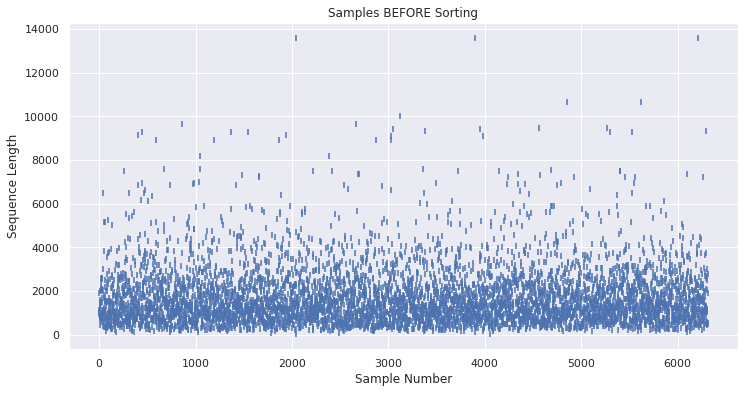

In [142]:
import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
#sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

plt.scatter(range(0, len(unsorted_lengths)), unsorted_lengths, marker="|")

plt.xlabel('Sample Number')
plt.ylabel('Sequence Length')
plt.title('Samples BEFORE Sorting')

plt.show()
del unsorted_lengths

## References


1. Macedo Maia, and Markus Endres *A comparative study using different question context information on pairwise learning-to-rank CQA transformer models in the home improvement domain*, Journal of Data Intelligence, Vol. 3, No. 1 (2021) 131–148

2. Zhuang Liu , Degen Huang, Kaiyu Huang, Zhuang Li and Jun Zhao *FinBERT: A Pre-trained Financial Language Representation Model for Financial Text Mining*, Proceedings of the Twenty-Ninth International Joint Conference on Artificial Intelligence (IJCAI-20) Special Track on AI in FinTech

3. \Zhiyu Chen, Wenhu Chen, Charese Smiley, Sameena Shah, Iana Borova, Dylan Langdon, Reema Moussa, Matt Beane, Ting-Hao Huang, Bryan Routledge and William Yang Wang, \emph{FINQA: A Dataset of Numerical Reasoning over Financial Data}, 2021.

4. Bithiah Yuan, *FinBERT-QA: Financial Question Answering with pre-trained BERT Language Models*, Master’s Thesis, Albert-Ludwigs-University Freiburg, Faculty of Engineering, Department of Computer Science, 2020.

5. Suman Karanjit, *Question and Answering Using BERT*, Computer Science Major Minnesota State University Moorhead, 2021.

6. Christopher Manning and Pandu Nayak. *Information Retrieval and Web Search.* 2019. url: https://web.stanford.edu/class/cs276/.

7. Peilin Yang, Hui Fang, and Jimmy Lin. *Anserini: Enabling the Use of Lucene for Information Retrieval Research}. In: Proceedings of the 40th International ACM SIGIR Conference on Research and Development in Information Retrieval*, Shinjuku, Tokyo, Japan, August 7-11, 2017. Ed. by Noriko Kando et al. ACM, 2017, pp. 1253–1256. doi: 10.1145/3077136.3080721. url: https://doi.org/ 10.1145/3077136.3080721.

8.  Moussa Taifi, *MRR vs MAP vs NDCG: Rank-Aware Evaluation Metrics And When To Use Them*, https://medium.com/swlh/rank-aware-recsys-evaluation-metrics-5191bba16832

